# Training UNet for drop segmentation

In [1]:
import torch

In [2]:
config = {
    "lr": 0.001,
    "batch_size": 16,
    "epochs": 20,
    "threshold": 0.3,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint": "checkpoint.pt"
}
print(f"Training using {config['device']}")

Training using cuda


In [3]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 39 batches
Val: 67 images, 5 batches


In [14]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_weights
model = UNet(3).to(config['device'])
init_weights(model, torch.nn.init.normal_, mean=0., std=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

model.train()

UNet(
  (ups): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReL

In [15]:
def check_accuracy_and_save(model, optimizer, epoch, train_loss):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
    }, config["checkpoint"])

    dice_score = 0
    model.eval()

    losses = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss)
            
            smooth = 0.01
            dice_score = (2 * (pred * y).sum() + smooth) / (
                (pred + y).sum() + smooth
            )
    mean_loss = sum(losses) / len(losses)
    mean_dice = dice_score / len(val_dataset)
    print(f"Valid loss: {mean_loss}")
    print(f"Dice Score: {mean_dice}")
    model.train()

In [16]:
from tqdm.notebook import tqdm
from sys import stdout
def train():
    for epoch in range(config['epochs']):
        print("Epoch", epoch)
        loader = tqdm(train_loader)
        losses = []
        
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)

        mean_loss = sum(losses) / len(losses)
        print("Train loss:   ", mean_loss)
        check_accuracy_and_save(model, optimizer, epoch, mean_loss)

In [17]:
train()

Epoch 0


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    5.716776505494729
Valid loss: 4.6281514167785645
Dice Score: 0.004324540961533785
Epoch 1


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    2.673665859760382
Valid loss: 2.050891637802124
Dice Score: 0.006547187454998493
Epoch 2


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    1.3140631455641527
Valid loss: 1.4685825109481812
Dice Score: 0.009096533060073853
Epoch 3


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.9465838655447348
Valid loss: 1.096760869026184
Dice Score: 0.005383456591516733
Epoch 4


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.793314936833504
Valid loss: 0.7340189814567566
Dice Score: -0.026711510494351387
Epoch 5


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.6601171447680547
Valid loss: 0.5788353681564331
Dice Score: 0.00709900725632906
Epoch 6


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.5782931844393412
Valid loss: 0.5466081500053406
Dice Score: 0.0786641463637352
Epoch 7


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.5516801621669378
Valid loss: 0.5421566367149353
Dice Score: 0.004925594665110111
Epoch 8


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.5326049495966007
Valid loss: 0.5176798701286316
Dice Score: 0.02519220858812332
Epoch 9


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.509904649013128
Valid loss: 0.4894113540649414
Dice Score: -0.0020763494540005922
Epoch 10


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.5083174063609197
Valid loss: 0.4796277582645416
Dice Score: 0.002901691012084484
Epoch 11


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.49976790868319
Valid loss: 0.5146581530570984
Dice Score: 0.0042676557786762714
Epoch 12


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.49414468652162796
Valid loss: 0.48786741495132446
Dice Score: 0.0305522158741951
Epoch 13


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.47148693601290387
Valid loss: 0.44723477959632874
Dice Score: 0.0030287066474556923
Epoch 14


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.465930557403809
Valid loss: 0.4519927203655243
Dice Score: 0.003404086222872138
Epoch 15


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.45600336713668627
Valid loss: 0.4715753197669983
Dice Score: -0.008023744449019432
Epoch 16


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.4473786568030333
Valid loss: 0.4613274037837982
Dice Score: 0.0007951428415253758
Epoch 17


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.4456135859856239
Valid loss: 0.4179461598396301
Dice Score: -0.001216154545545578
Epoch 18


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.4600114188133142
Valid loss: 0.40444302558898926
Dice Score: -0.038301099091768265
Epoch 19


  0%|          | 0/39 [00:00<?, ?it/s]

Train loss:    0.44493022102576035
Valid loss: 0.3977433443069458
Dice Score: -0.01808573119342327


# Estimation

In [50]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0][0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

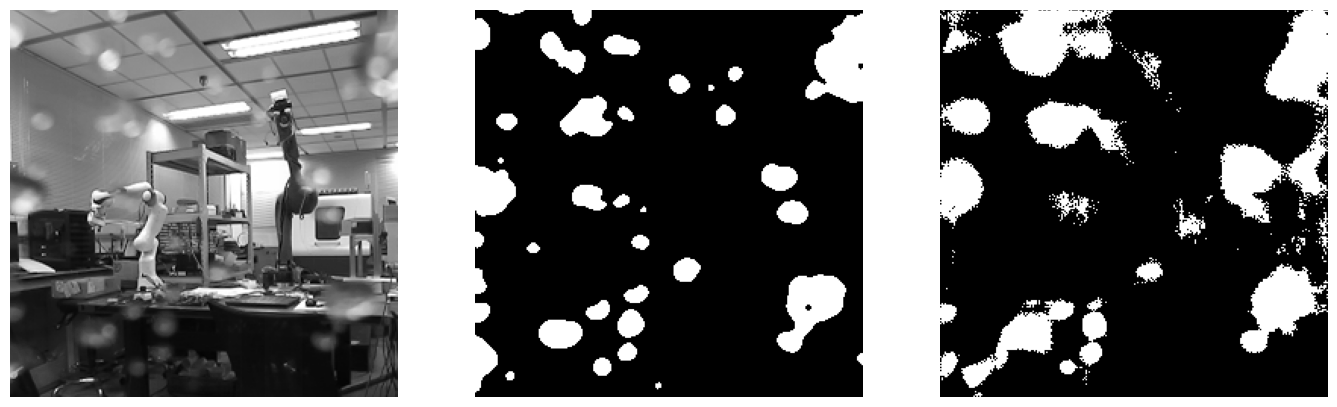

In [56]:
idx = 30
x, y = val_dataset.dataset[idx]
x = torch.stack([x])
y = torch.stack([y])
x, y, pred = predict(model, x, y, binary_map=True)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(17, 10))
axs[0].imshow(x, cmap='gray')
axs[1].imshow(y, cmap='gray')
axs[2].imshow(pred, cmap='gray')
for ax in axs:
    ax.axis('off')